# TileDB Groups

This notebook shows an example of how to use the `Group` and `GroupSchema` classes from TileDB-CF to create, inspect, open, read, and write data to arrays in a TileDB group.

### Data

The following arrays will be created that share some of their dimensions:

* `D_xyt` is a dense array with dimensions (`Dx`,`Dy`,`Dt`)
* `D_xy` is a dense array with dimensions (`Dx`,`Dy`)
* `D_t` is a dense array with dimension (`Dt`)
* `S_xyzt` is a sparse array with dimensions (`Sx`,`Sy`,`Sz`,`St`)
* The values ofthe dimensions are stored in separate arrays

### Packages

Import the libraries used in this notebook:

In [1]:
import numpy as np
import tiledb
from tiledb.cf import Group, GroupSchema
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

## Create numpy arrays

Variables to set the size of the arrays:

In [2]:
t_size = 365
dense_size = 100
sparse_size = 2000

Functions used to create a dataset:

In [3]:
def ripple(x,y,t):
    return (np.sin(t*(x**2+y**2))/t)

def ripple2(x,y,z,t):
    return (np.sin(t*(x**2+y**2))/t)+z

### Data for the dense arrays

In [4]:
Dx_values = np.arange(dense_size)+1
Dy_values = np.arange(dense_size)+1
Dt_values = np.arange(t_size)+1

D_xyt_values = \
    np.fromfunction(lambda Dx_values, Dy_values, Dt_values: ripple(Dx_values, Dy_values, Dt_values), 
                    (dense_size,dense_size,t_size))

D_xy_values = np.nanmean(D_xyt_values, axis=2)
D_t_values = np.mean(D_xyt_values, axis=(0, 1))

/usr/local/Caskroom/miniconda/base/envs/netcdf-dev/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


### Data for the sparse arrays

In [5]:
Sx_values = np.random.randint(dense_size, size=(sparse_size))+1
Sy_values = np.random.randint(dense_size, size=(sparse_size))+1
Sz_values = np.random.randint(dense_size, size=(sparse_size))+1
St_values = np.random.randint(t_size, size=(sparse_size))+1

S_xyzt_values = ripple2(Sx_values,Sy_values,Sz_values,St_values)

## Create the TileDB Group

### Create the GroupSchema 
* [ArraySchema](https://tiledb-inc-tiledb-py.readthedocs-hosted.com/en/stable/python-api.html#array-schema) 
* [Domain](https://tiledb-inc-tiledb-py.readthedocs-hosted.com/en/stable/python-api.html#domain)
* [Attributes](https://tiledb-inc-tiledb-py.readthedocs-hosted.com/en/stable/python-api.html#tiledb.Attr)
* [Dimensions](https://tiledb-inc-tiledb-py.readthedocs-hosted.com/en/stable/python-api.html#dimension) 

In [6]:
Dx = tiledb.Dim(name="Dx", domain=(1, dense_size), tile=10, dtype=np.uint64)
Dy = tiledb.Dim(name="Dy", domain=(1, dense_size), tile=10, dtype=np.uint64)
Dt = tiledb.Dim(name="Dt", domain=(1, t_size), tile=10, dtype=np.uint64)
Sx = tiledb.Dim(name="Sx", domain=(1, sparse_size), tile=10, dtype=np.uint64)
Sy = tiledb.Dim(name="Sy", domain=(1, sparse_size), tile=10, dtype=np.uint64)
Sz = tiledb.Dim(name="Sz", domain=(1, sparse_size), tile=10, dtype=np.uint64)
St = tiledb.Dim(name="St", domain=(1, t_size), tile=10, dtype=np.uint64)

In [7]:
group_schema = GroupSchema(
    { 
        "xyt_dense": tiledb.ArraySchema(
            domain=tiledb.Domain(Dx,Dy,Dt), 
            attrs=[
                tiledb.Attr(name="D_xyt", dtype=np.float64), 
 
            ],
         ),
        "xy_dense": tiledb.ArraySchema(
            domain=tiledb.Domain(Dx,Dy), 
            attrs=[
                tiledb.Attr(name="D_xy", dtype=np.float64), 

            ],
         ),
        "t_dense": tiledb.ArraySchema(
            domain=tiledb.Domain(Dt), 
            attrs=[
                tiledb.Attr(name="D_t", dtype=np.float64), 

            ],
        ),
        "xyzt_sparse": tiledb.ArraySchema(
            domain=tiledb.Domain(Sx,Sy,Sz,St), 
            attrs=[
                tiledb.Attr(name="S_xyzt", dtype=np.float64), 
            ],
            sparse=True,
            allows_duplicates=True,
        ),
        "Dxy": tiledb.ArraySchema(
            domain=tiledb.Domain(Dx), 
            attrs=[
                tiledb.Attr(name="x", dtype=np.uint64), 
                tiledb.Attr(name="y", dtype=np.uint64), 
            ],
         ),
        "Dt": tiledb.ArraySchema(
            domain=tiledb.Domain(Dt), 
            attrs=[
                tiledb.Attr(name="t", dtype=np.uint64), 
            ],
        ),
        "Sxyzt": tiledb.ArraySchema(
            domain=tiledb.Domain(Sx), 
            attrs=[
                tiledb.Attr(name="x", dtype=np.uint64), 
                tiledb.Attr(name="y", dtype=np.uint64), 
                tiledb.Attr(name="z", dtype=np.uint64), 
                tiledb.Attr(name="t", dtype=np.uint64), 
            ],
            sparse=True,
            allows_duplicates=True,
         ),}
)

### Create the TileDB Group on disk

In [8]:
!rm -r output/example_group

In [9]:
group_uri = "output/example_group"
if tiledb.object_type(group_uri) is None:
    Group.create("output/example_group", group_schema)

In [10]:
group_schema = GroupSchema.load(group_uri)
group_schema

GroupSchema:
Group metadata schema: ArraySchema(
  domain=Domain(*[
    Dim(name='dim', domain=(0, 0), tile='1', dtype='int32'),
  ]),
  attrs=[
    Attr(name='attr', dtype='int32', var=False, nullable=False),
  ],
  cell_order='row-major',
  tile_order='row-major',
  capacity=10000,
  sparse=False,
  coords_filters=FilterList([ZstdFilter(level=-1)]),
)
'Dt': ArraySchema(
  domain=Domain(*[
    Dim(name='Dt', domain=(1, 365), tile='10', dtype='uint64'),
  ]),
  attrs=[
    Attr(name='t', dtype='uint64', var=False, nullable=False),
  ],
  cell_order='row-major',
  tile_order='row-major',
  capacity=10000,
  sparse=False,
  coords_filters=FilterList([ZstdFilter(level=-1)]),
)
'Dxy': ArraySchema(
  domain=Domain(*[
    Dim(name='Dx', domain=(1, 100), tile='10', dtype='uint64'),
  ]),
  attrs=[
    Attr(name='x', dtype='uint64', var=False, nullable=False),
    Attr(name='y', dtype='uint64', var=False, nullable=False),
  ],
  cell_order='row-major',
  tile_order='row-major',
  capacity=1000

### Write data to the TileDB Group

#### Dense arrays

Specify the name attribute (`attr`) of where to write the data to. 

In [11]:
with Group(group_uri, attr="D_xyt", mode="w") as group:
    group.array[:] = D_xyt_values
    
with Group(group_uri, attr="D_xy", mode="w") as group:
    group.array[:] = D_xy_values   

with Group(group_uri, attr="D_t", mode="w") as group:
    group.array[:] = D_t_values

#### Sparse array

Specify the name attribute (`attr`) of where to write the data to. When writing to a sparse array add the values of the dimensions to `group.array[]`.

In [12]:
with Group(group_uri, attr="S_xyzt", mode="w") as group:
    group.array[Sx_values,Sy_values,Sz_values,St_values] = S_xyzt_values

#### Dimension arrays

The attribute names of the dimensions have the same name in multiple arrays. Specify both the name of the `array` and the attribute (`attr`) of where to write the data to. 

Also note the difference of writing data to a dense and sparse array:

In [13]:
with Group(group_uri, array="Dxy", attr="x", mode="w") as group:
    group.array[:] = Dx_values

with Group(group_uri, array="Dxy", attr="y", mode="w") as group:
    group.array[:] = Dy_values

with Group(group_uri, array="Dt", attr="t", mode="w") as group:
    group.array[:] = Dt_values

with Group(group_uri, array="Sxyzt", mode="w") as group:
    group.array[np.arange(sparse_size)+1] = {"x": Sx_values, "y": Sy_values, "z": Sz_values, "t": St_values}

#### Group metadata

In [14]:
#  2. writing to group metadata (using `group.meta`)

#### Array metadata

In [15]:
#  3. writing to array metadata (using `group.array_metadata` or `group.array.meta`)

#### Attribute metadata

In [16]:
#  4. writing to attribute metadata (using `group.get_attr_metadata`)

### Read data from the TileDB Group

In [17]:
# Show reading data from the group. Maybe add a plot after reading? Includes:
# 1. reading values from the group using both opening by `Group(array=...)` and opening by `Group(attr=...)`
# 2. show the different between metadata with `group.array_metadata` and `group.array.meta`
# 3. read attribute metadata using `group.get_attr_metadata`
# 4. read group level metadata with `group.meta`

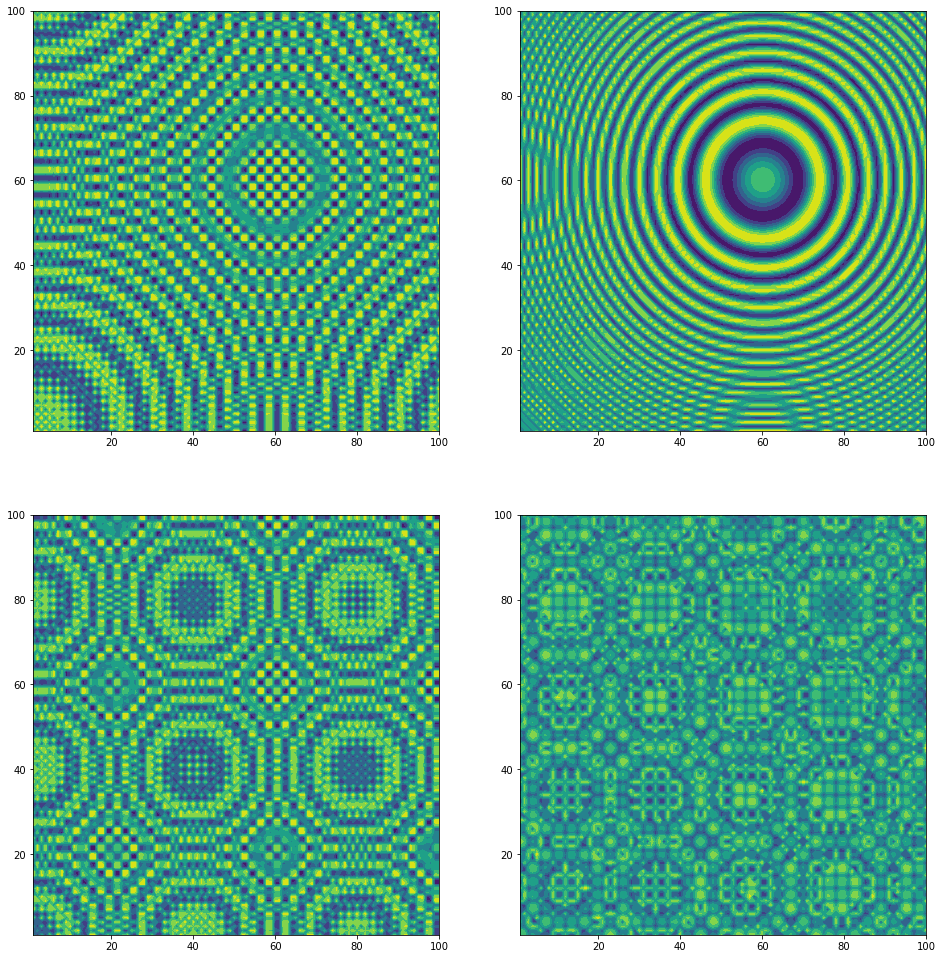

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(16, 17))
axes[0,0].contourf(Dx_values, Dy_values, D_xyt_values[:,:,33]);
axes[0,1].contourf(Dx_values, Dy_values, D_xyt_values[:,:,66]);
axes[1,0].contourf(Dx_values, Dy_values, D_xyt_values[:,:,99]);
axes[1,1].contourf(Dx_values, Dy_values, D_xy_values);